In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
from scipy.stats import randint, uniform

%matplotlib inline

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Checking data frame. Data only contains numerical inputs from V1 to V28

# EDA

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


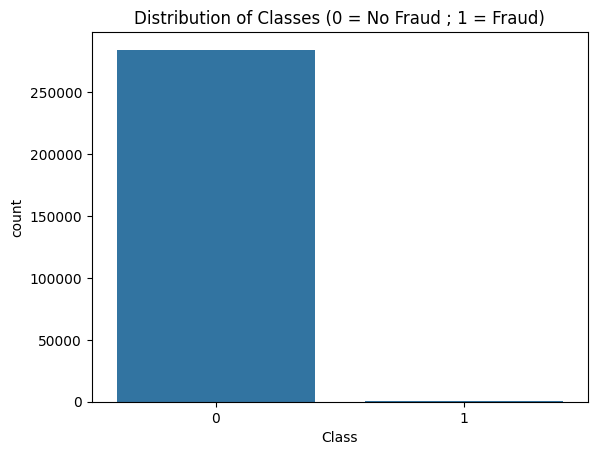

In [3]:
# Distribution of fraud class
sns.countplot(x = 'Class', data = df);
plt.title('Distribution of Classes (0 = No Fraud ; 1 = Fraud)');
plt.show

print(df['Class'].value_counts(normalize = True)) # percentage of fraud and no fraud cases

Fraud cases are extremely rare (only 0.172% of all transactions)

In [4]:
print(df.describe())
print(df.shape)

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [5]:
df.info()
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

No missing values or duplicate rows found.

# Correlation Heat Map

Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


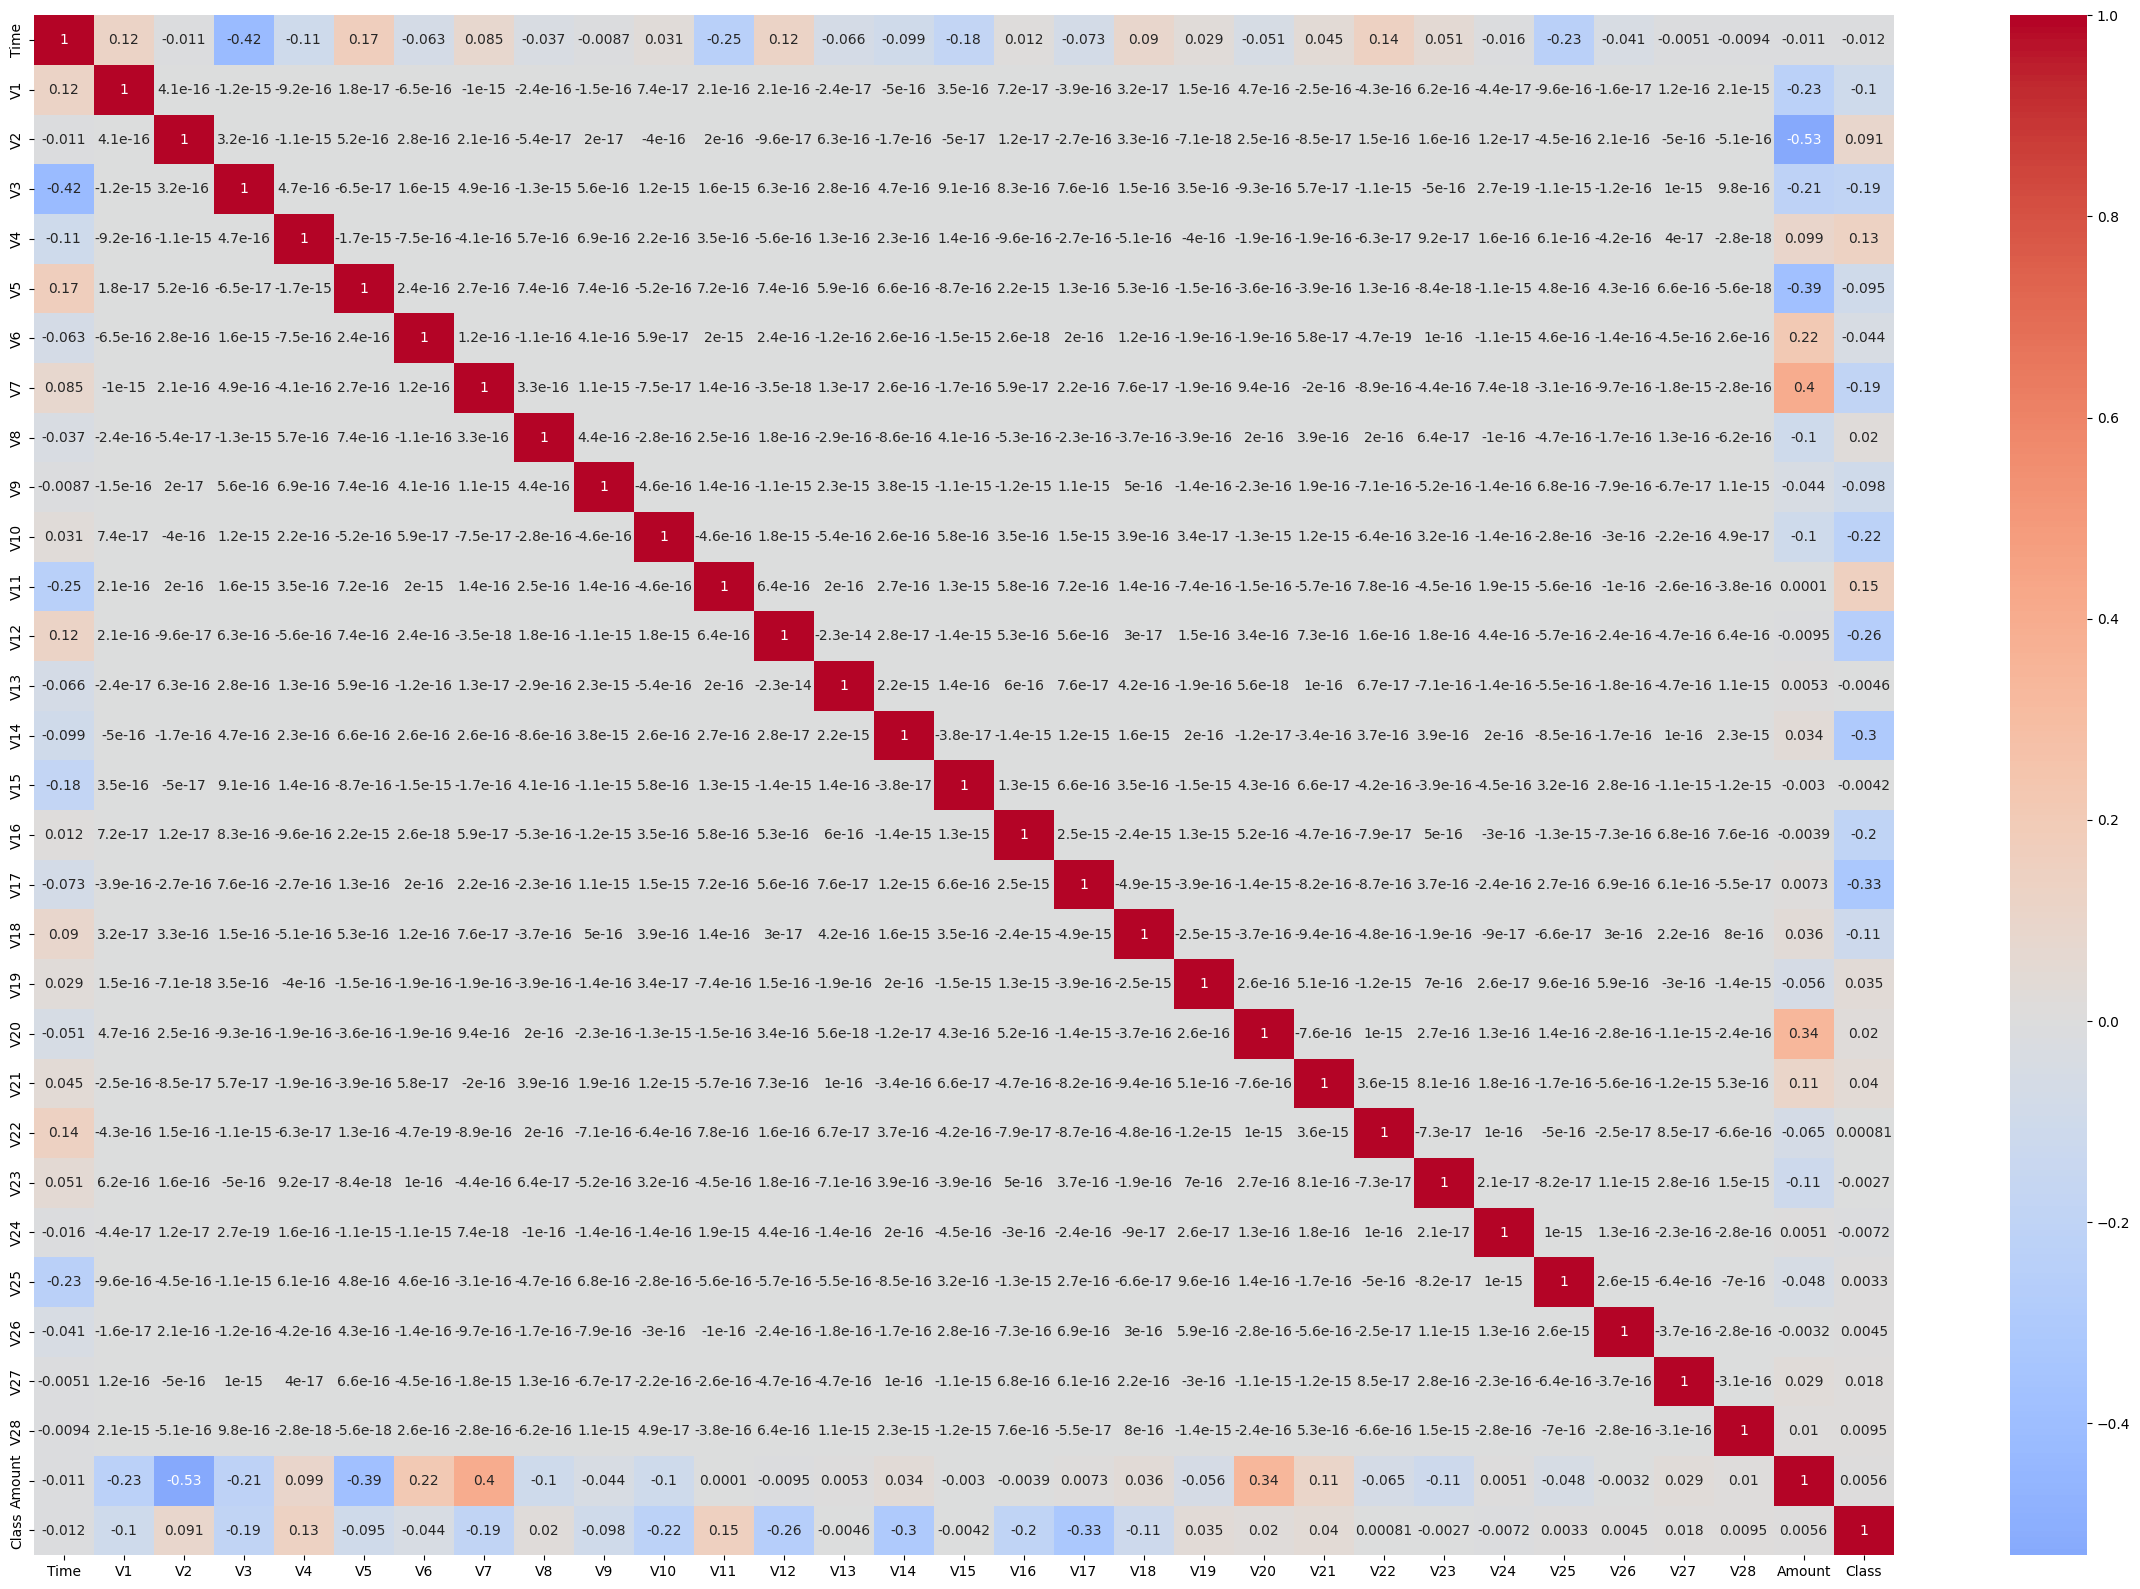

In [6]:
# Correlation heat map to see if any variables are highly correlated to class
correlation_mat = df.corr()

plt.figure(figsize = (30,20))
sns.heatmap(correlation_mat,cmap = 'coolwarm', annot = True, center = 0)

corr_with_class = correlation_mat['Class'].sort_values(ascending = False)
print(corr_with_class)

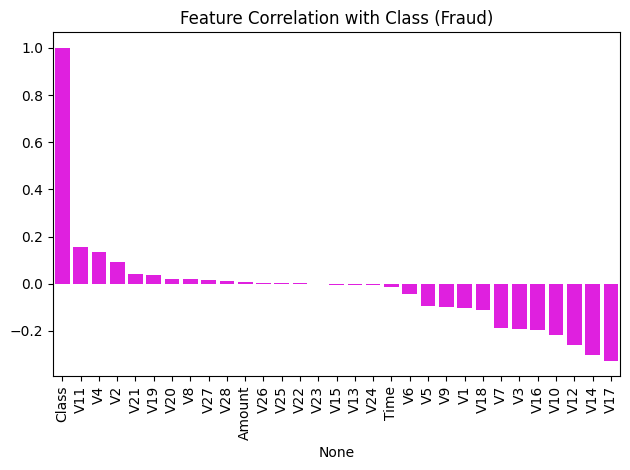

In [7]:
# Heatmap with Class Correlation values only
plt.figure
sns.barplot(x = corr_with_class.index, y = corr_with_class.values, color = 'magenta')
plt.xticks(rotation = 90)
plt.title("Feature Correlation with Class (Fraud)")
plt.tight_layout()
plt.show()

### Boxplot with Features that are most revelant to Fraud detection [Gives a good idea of what variables to inculde in our model generation]

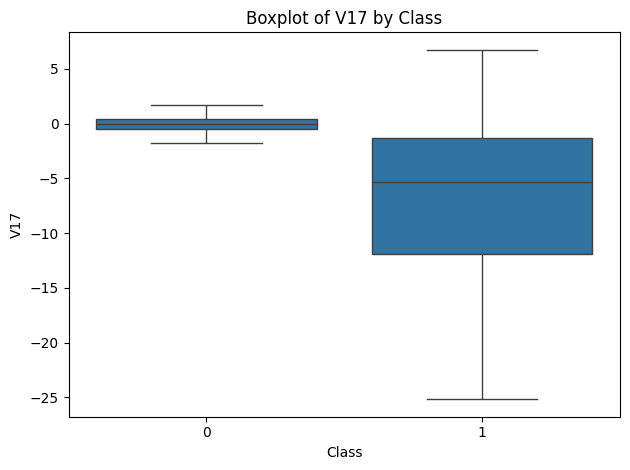

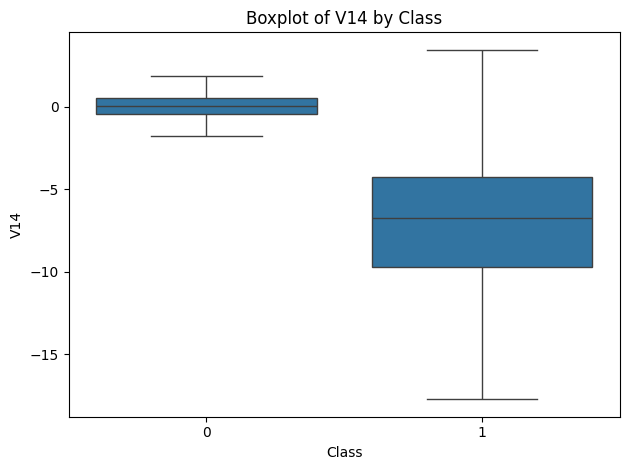

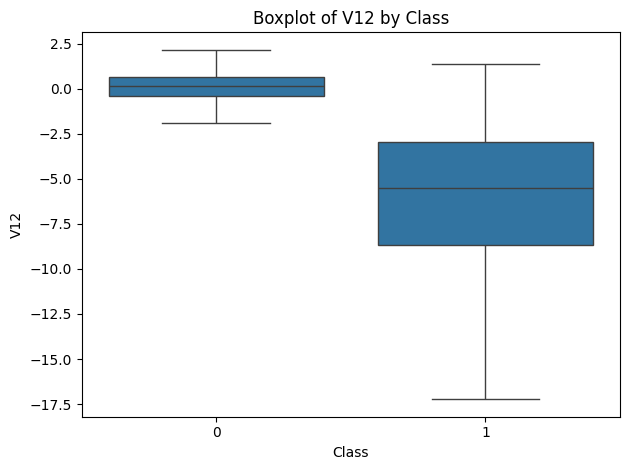

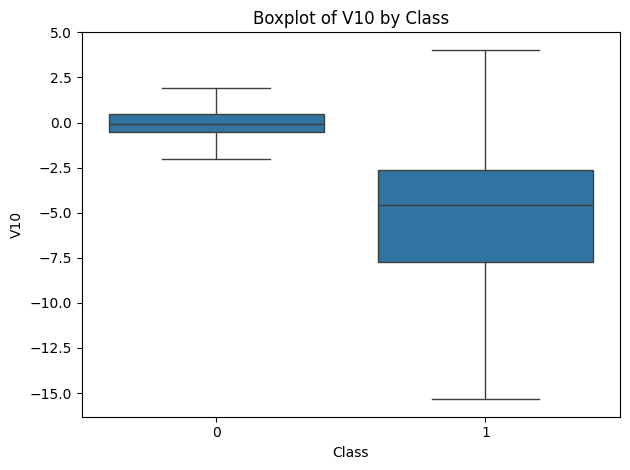

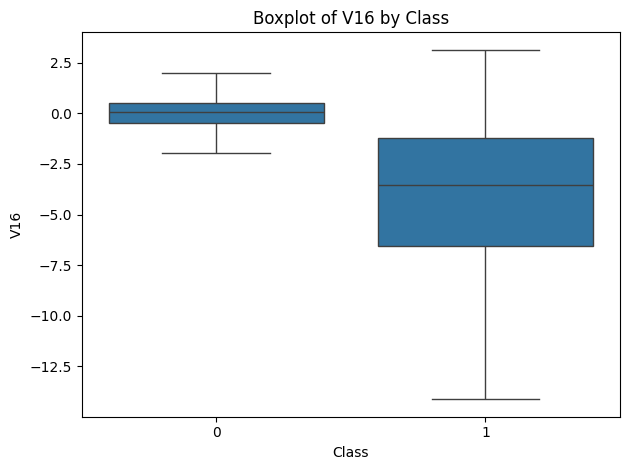

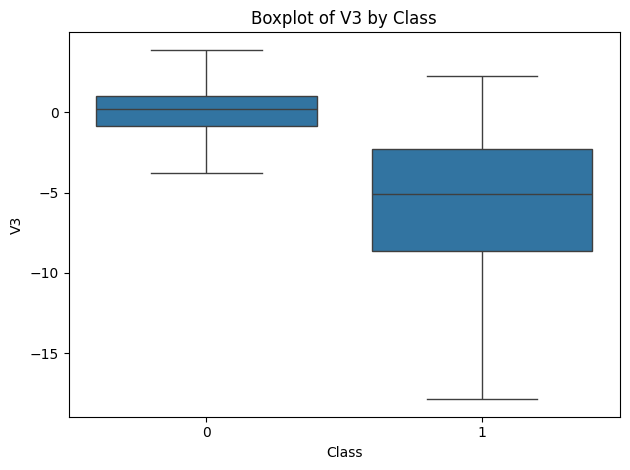

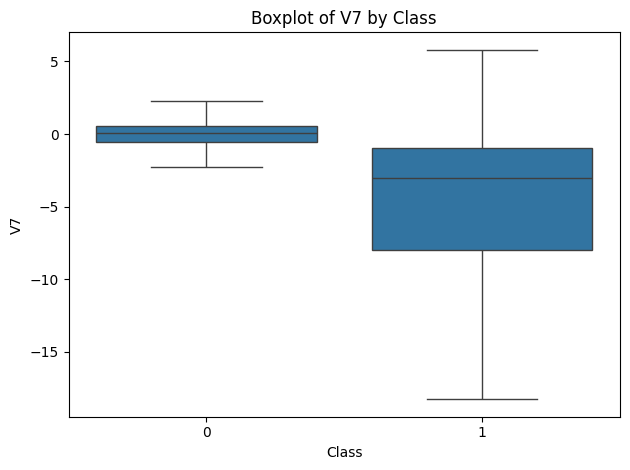

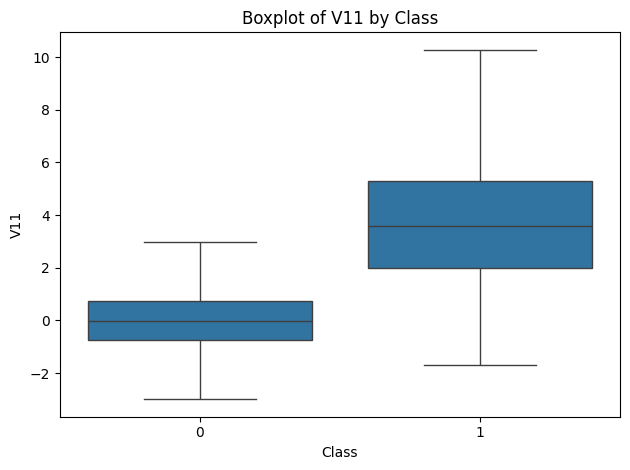

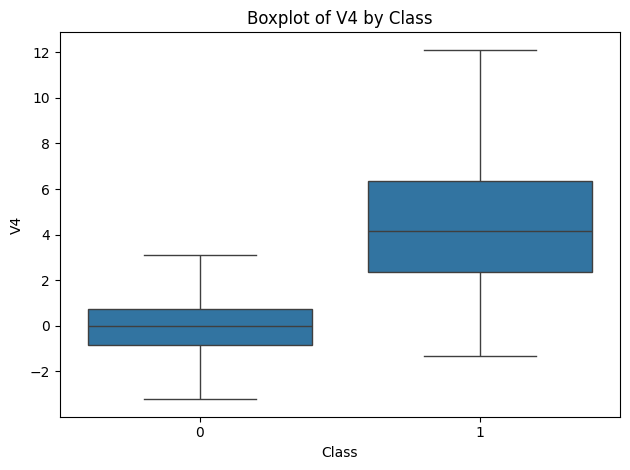

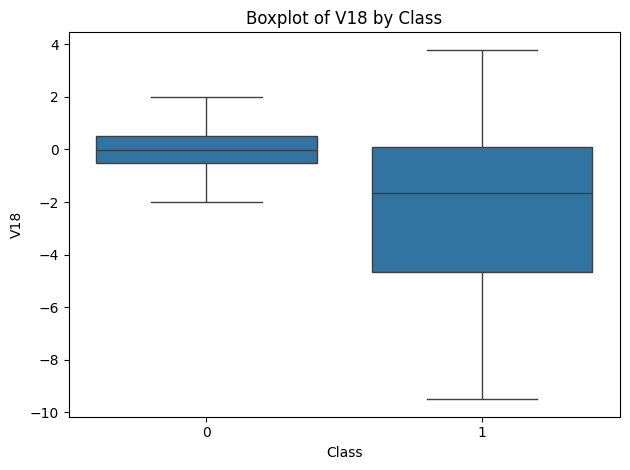

In [8]:
# Compute correlations with Class
correlations = df.corr()['Class'].drop('Class').abs().sort_values(ascending = False)

# Top 10 correlation
top_correlations = correlations.head(10).index

# Plot boxplot for top features
for column in top_correlations:
    sns.boxplot(x = 'Class', y = column, data = df, showfliers = False)
    plt.title(f'Boxplot of {column} by Class')
    plt.tight_layout()
    plt.show()

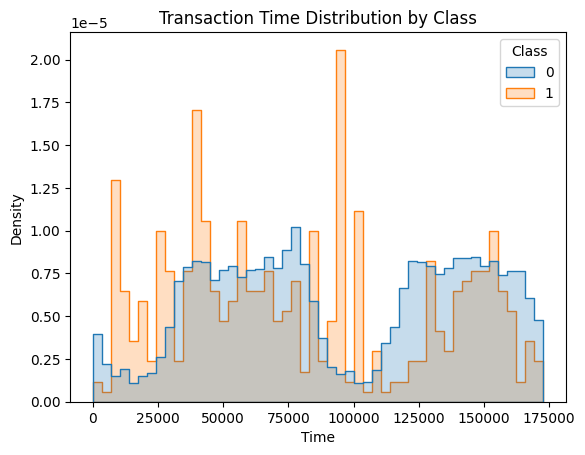

In [9]:
sns.histplot(data = df, x = "Time", hue = "Class", bins = 50, element = "step", stat = "density", common_norm = False)
plt.title("Transaction Time Distribution by Class")
plt.show()

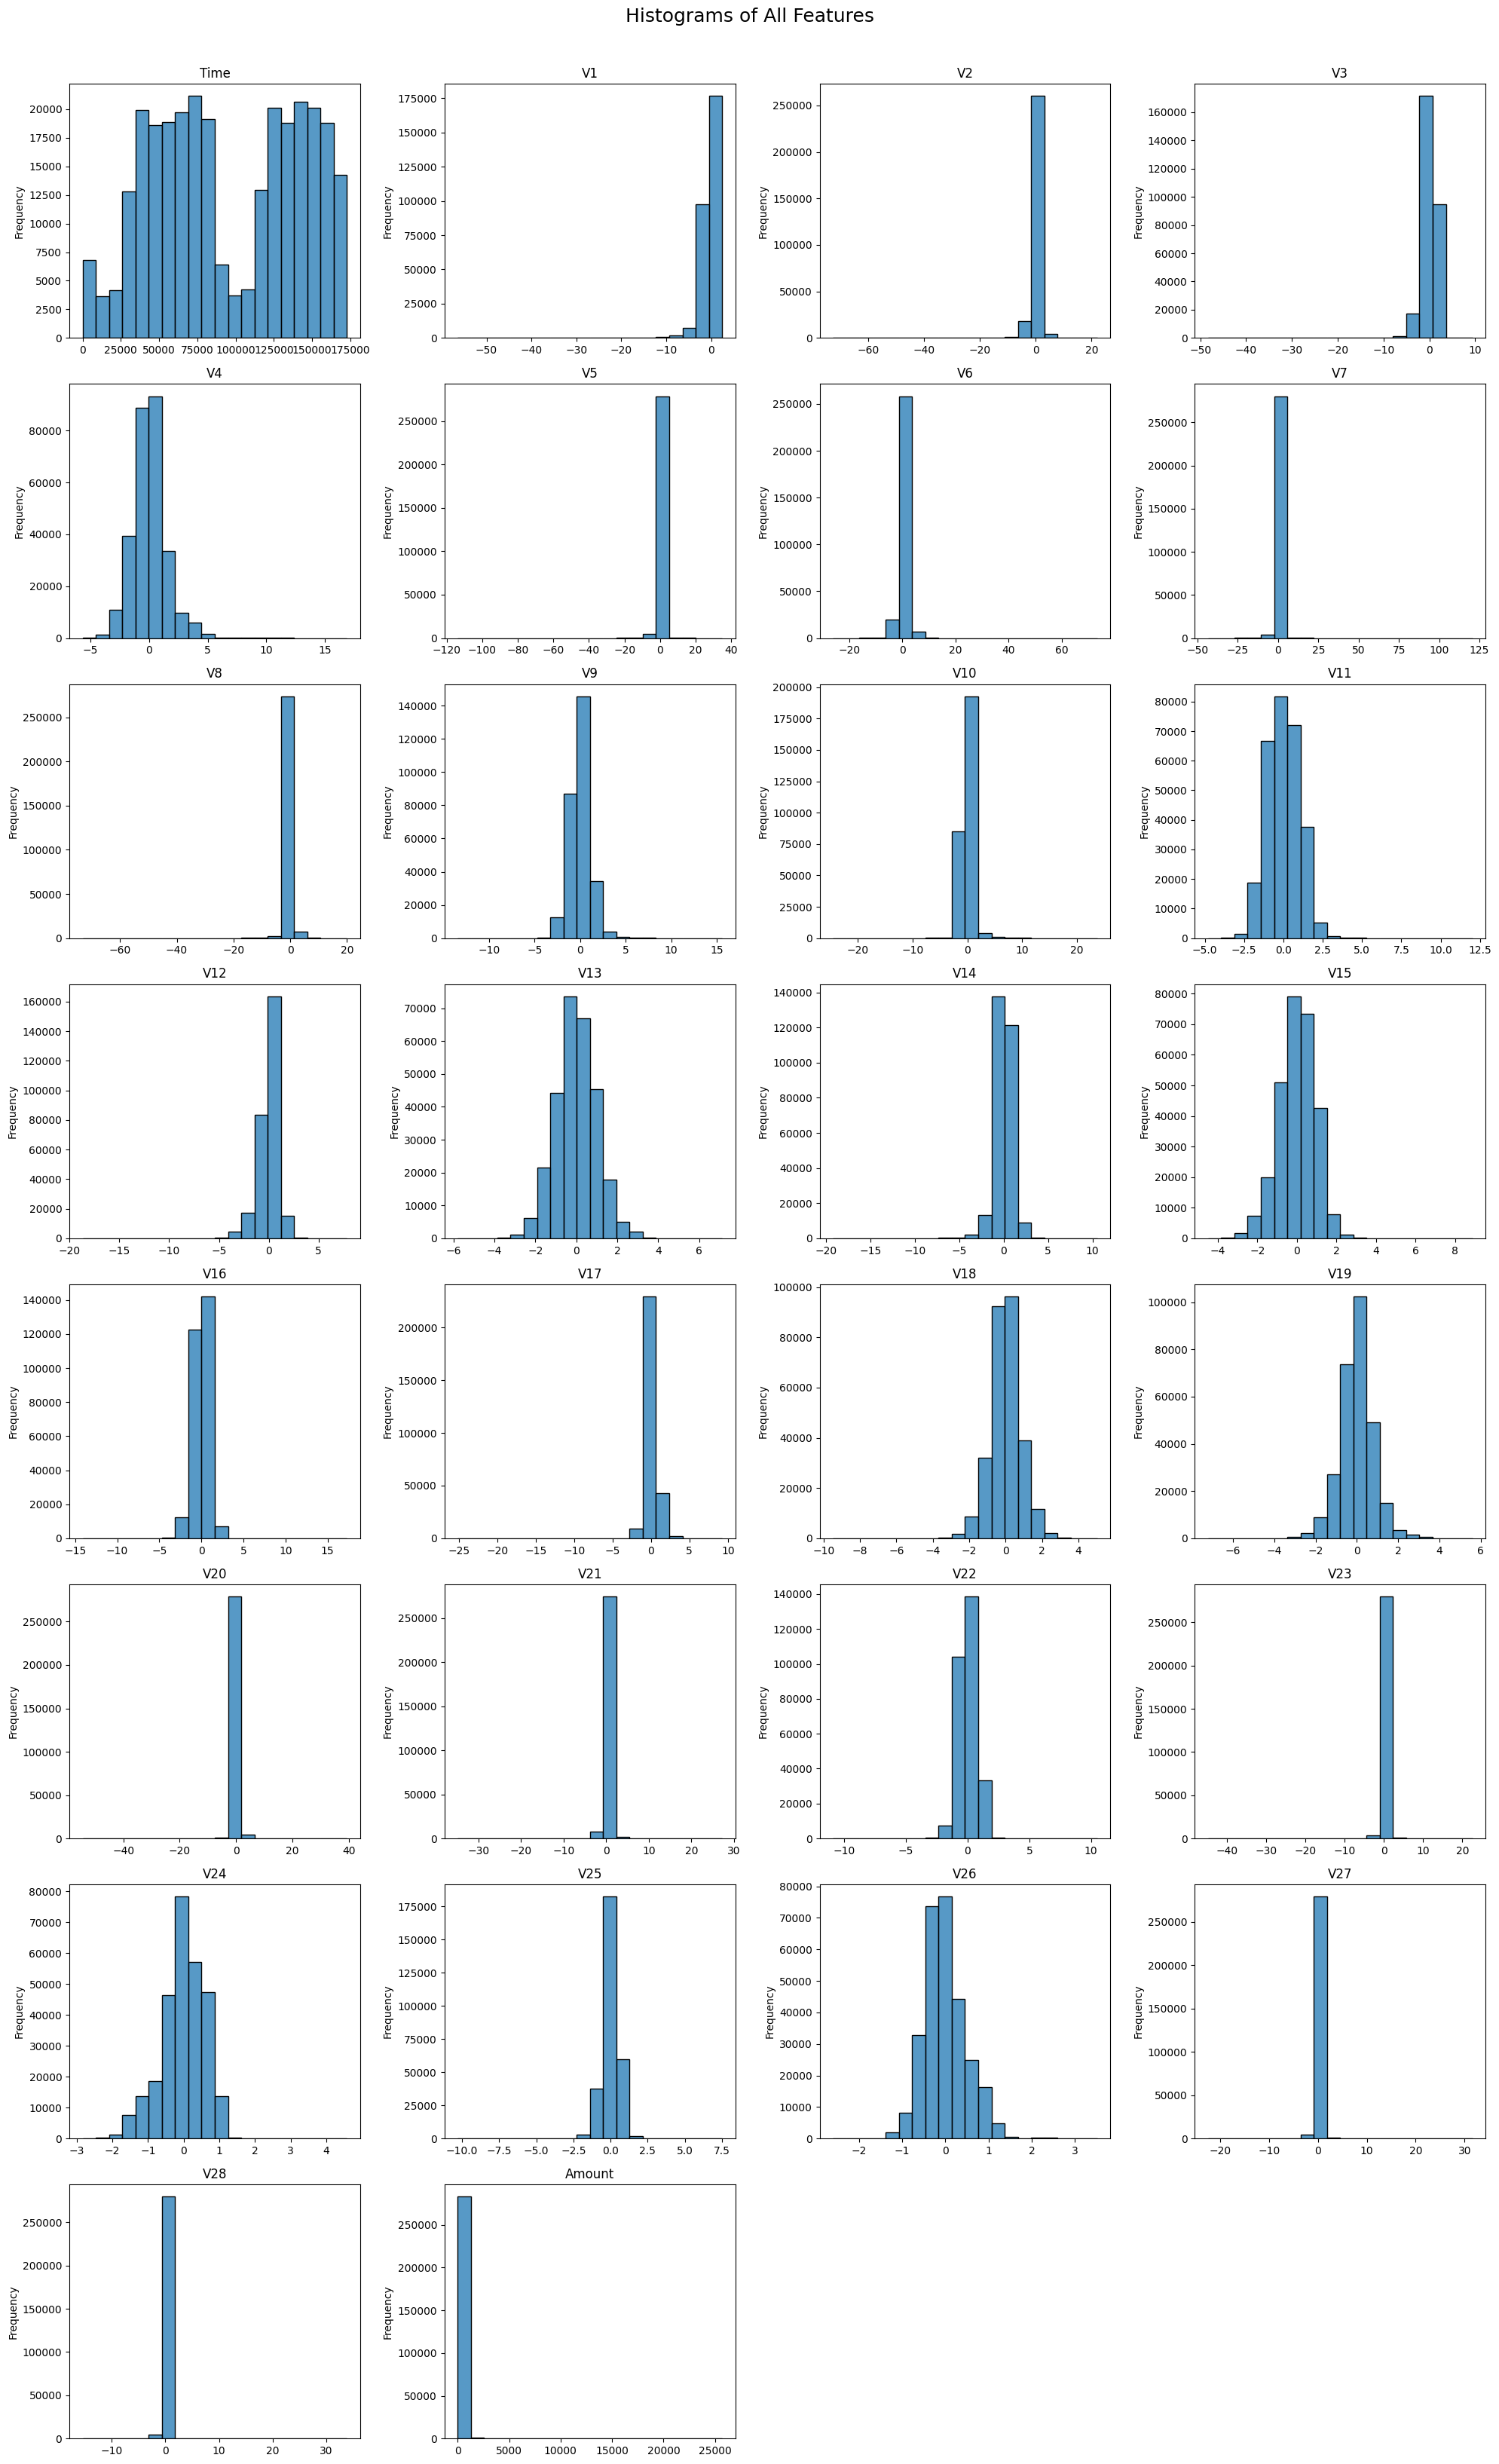

In [10]:
# Histogrm to visualize centrality and distribution
columns_to_plot = df.drop('Class', axis = 1).columns
n_cols = 4
n_rows = int(np.ceil(len(columns_to_plot) / n_cols))

plt.figure(figsize = (n_cols * 5, n_rows * 4))

for i, var in enumerate(columns_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[var], kde = False, bins = 20)
    plt.title(f'{var}')
    plt.xlabel('')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Histograms of All Features', fontsize = 18, y = 1.02)
plt.show()

## SMOTE for Imbalanced Data

In [11]:
# Applying SMOTE for imbalanced class types
X = df.drop('Class', axis = 1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Apply smote
smote = SMOTE(random_state = 42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'Original dataset shape: {y_train.value_counts()}')
print(f'Resampled dataset shape: {y_train_smote.value_counts()}')

Original dataset shape: Class
0    227451
1       394
Name: count, dtype: int64
Resampled dataset shape: Class
0    227451
1    227451
Name: count, dtype: int64


In [12]:
# Standardize features (important for SVM and MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Strategies

## Linear SVM

In [13]:
svm_model = LinearSVC(max_iter = 10000, random_state = 42)
svm_model.fit(X_train_scaled, y_train)

preds_svm = svm_model.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, preds_svm))
print(classification_report(y_test, preds_svm))

Confusion Matrix:
 [[56852    12]
 [   40    58]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.59      0.69        98

    accuracy                           1.00     56962
   macro avg       0.91      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [14]:
# Linear SVM hyperparameter tuning
svm_tune = LinearSVC(max_iter = 10000, random_state = 42)

svm_params = {
    'C': uniform(0.001, 10),
    'class_weight': [None, 'balanced']
}

svm_search = RandomizedSearchCV(
    svm_tune,
    param_distributions = svm_params,
    n_iter = 20,
    scoring = 'f1',
    cv = 3,
    n_jobs = -1,
    verbose = 2,
    random_state = 42
)
svm_search.fit(X_train_scaled, y_train)

print("Best Linear SVM parameters:", svm_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Linear SVM parameters: {'C': np.float64(3.746401188473625), 'class_weight': None}


In [15]:
# Retrain linear svm model
best_svm = LinearSVC(**svm_search.best_params_, random_state = 42, max_iter = 5000)
best_svm.fit(X_train_scaled, y_train)

preds_svm = best_svm.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, preds_svm))
print(classification_report(y_test, preds_svm))

Confusion Matrix:
 [[56852    12]
 [   40    58]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.59      0.69        98

    accuracy                           1.00     56962
   macro avg       0.91      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



## Neural Network (MLP)

In [16]:
mlp_model = MLPClassifier(
    hidden_layer_sizes = (50,),
    max_iter = 500,
    random_state = 42,
    early_stopping = True
)
mlp_model.fit(X_train_scaled, y_train)

probs_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]
preds_mlp = mlp_model.predict(X_test_scaled)
# preds_mlp = (probs_mlp >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, probs_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_mlp))
print(classification_report(y_test, preds_mlp))

AUC: 0.9805382409013127
Confusion Matrix:
 [[56855     9]
 [   25    73]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.74      0.81        98

    accuracy                           1.00     56962
   macro avg       0.94      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [17]:
# Neural network hyperparameter tuning
mlp_tune = MLPClassifier(max_iter = 300, random_state = 42, early_stopping = True)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

mlp_search = RandomizedSearchCV(
    mlp_tune,
    param_distributions = mlp_params,
    scoring = 'f1',
    cv = 3,
    n_jobs = -1,
    verbose = 2
)
mlp_search.fit(X_train_scaled, y_train)

print("Best MLP parameters:", mlp_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best MLP parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'alpha': 0.001, 'activation': 'tanh'}


In [18]:
# Retrain neural net model
best_mlp = MLPClassifier(**mlp_search.best_params_, random_state = 42, early_stopping = True)
best_mlp.fit(X_train_scaled, y_train)

probs_mlp = best_mlp.predict_proba(X_test_scaled)[:, 1]
preds_mlp = best_mlp.predict(X_test_scaled)

print("AUC:", roc_auc_score(y_test, probs_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_mlp))
print(classification_report(y_test, preds_mlp))

AUC: 0.9768028694313966
Confusion Matrix:
 [[56851    13]
 [   18    80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.82      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



## Naive Bayes (Gaussian)

In [19]:
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

probs_nb = nb_model.predict_proba(X_test_scaled)[:, 1]
preds_nb = nb_model.predict(X_test_scaled)

print("AUC:", roc_auc_score(y_test, probs_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_nb))
print(classification_report(y_test, preds_nb))

AUC: 0.963247971529636
Confusion Matrix:
 [[55535  1329]
 [   15    83]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.85      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.91      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [20]:
# Naive bayes hyperparameter tuning
nb_params = {
    'var_smoothing': np.logspace(-9, -2, 8)
}

nb_search = RandomizedSearchCV(
    GaussianNB(),
    param_distributions = nb_params,
    n_iter = 8,
    scoring = 'f1',
    cv = 3,
    n_jobs = -1,
    verbose = 2,
    random_state = 42
)
nb_search.fit(X_train_scaled, y_train)

print("Best NB parameters:", nb_search.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best NB parameters: {'var_smoothing': np.float64(0.01)}


In [21]:
# Retrain naive bayes model
best_nb = GaussianNB(**nb_search.best_params_)
best_nb.fit(X_train_scaled, y_train)

probs_nb = best_nb.predict_proba(X_test_scaled)[:, 1]
preds_nb = best_nb.predict(X_test_scaled)

print("AUC:", roc_auc_score(y_test, probs_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_nb))
print(classification_report(y_test, preds_nb))

AUC: 0.9632567644390339
Confusion Matrix:
 [[55548  1316]
 [   15    83]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.85      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.91      0.55     56962
weighted avg       1.00      0.98      0.99     56962



## Logistic regression (baseline)

In [22]:
def best_threshold_by_f1(y_true, scores):
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    thresholds = np.append(thresholds, 1.0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-12)
    i = int(np.nanargmax(f1))
    return float(thresholds[i]), float(f1[i]), float(precision[i]), float(recall[i])

def evaluate(name, y_true, scores):
    roc = roc_auc_score(y_true, scores)
    pr = average_precision_score(y_true, scores)
    thr, f1, prec, rec = best_threshold_by_f1(y_true, scores)
    return {
        "Model": name,
        "ROC_AUC": roc,
        "PR_AUC": pr,
        "Best_F1": f1,
        "Best_Thresh": thr,
        "Precision@BestF1": prec,
        "Recall@BestF1": rec,
    }

results = []

# Logistic Regression
logreg_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter = 2000, class_weight = "balanced", solver = "lbfgs")),
])
logreg_model.fit(X_train, y_train)
logreg_scores = logreg_model.predict_proba(X_test)[:, 1]
results.append(evaluate("Logistic Regression (baseline)", y_test, logreg_scores))

## Decision Tree

In [23]:
# Decision Tree
dt_model = DecisionTreeClassifier(
    random_state = 42,
    class_weight = "balanced",
    min_samples_leaf = 2)
dt_model.fit(X_train, y_train)
dt_scores = dt_model.predict_proba(X_test)[:, 1]
results.append(evaluate("Decision Tree", y_test, dt_scores))

## Random Forest

In [24]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators = 400,
    random_state = 42,
    n_jobs = -1,
    class_weight = "balanced_subsample",
    min_samples_leaf = 2
)
rf_model.fit(X_train, y_train)
rf_scores = rf_model.predict_proba(X_test)[:, 1]
results.append(evaluate("Random Forest", y_test, rf_scores))

## XGBoost/LightGBM/fallback

In [25]:
# XGBoost / LightGBM / fallback
pos, neg = (y_train==1).sum(), (y_train==0).sum()
scale_pos_weight = neg / max(pos, 1)

try:
    xgb = XGBClassifier(
        random_state = 42,
        n_estimators = 500,
        max_depth = 3,
        learning_rate = 0.05,
        subsample = 0.8,
        colsample_bytree = 0.8,
        reg_lambda = 1.0,
        scale_pos_weight = scale_pos_weight,
        tree_method = "hist",
        eval_metric = "logloss"
    )
    xgb.fit(X_train, y_train)
    xgb_scores = xgb.predict_proba(X_test)[:, 1]
    results.append(evaluate("XGBoost", y_test, xgb_scores))
except Exception:
    try:
        lgbm = LGBMClassifier(
            random_state = 42,
            n_estimators = 800,
            learning_rate = 0.05,
            num_leaves = 31,
            subsample = 0.8,
            colsample_bytree = 0.8,
            reg_lambda = 1.0,
            scale_pos_weight = scale_pos_weight
        )
        lgbm.fit(X_train, y_train)
        lgbm_scores = lgbm.predict_proba(X_test)[:, 1]
        results.append(evaluate("LightGBM", y_test, lgbm_scores))
    except Exception:
        print("XGBoost/LightGBM not available. Using HistGradientBoosting as fallback.")
        hgb = HistGradientBoostingClassifier(max_iter = 500, learning_rate = 0.05, random_state = 42)
        hgb.fit(X_train, y_train)
        try:
            hgb_scores = hgb.predict_proba(X_test)[:, 1]
        except Exception:
            raw = hgb.decision_function(X_test)
            hgb_scores = 1 / (1 + np.exp(-raw))
        results.append(evaluate("HistGradientBoosting (fallback)", y_test, hgb_scores))

In [26]:
# Evaluate tuned models
svm_scores = best_svm.decision_function(X_test_scaled)
results.append(evaluate("Linear SVM", y_test, svm_scores))

mlp_scores = best_mlp.predict_proba(X_test_scaled)[:, 1]
results.append(evaluate("Neural Network (MLP)", y_test, mlp_scores))

nb_scores = best_nb.predict_proba(X_test_scaled)[:, 1]
results.append(evaluate("Naive Bayes (Gaussian)", y_test, nb_scores))

# Results
results_df = pd.DataFrame(results).sort_values("PR_AUC", ascending = False).reset_index(drop = True)
print(results_df.to_string(index = False))

                         Model  ROC_AUC   PR_AUC  Best_F1  Best_Thresh  Precision@BestF1  Recall@BestF1
                 Random Forest 0.964768 0.854731 0.874317     0.412421          0.941176       0.816327
          Neural Network (MLP) 0.976803 0.853069 0.842105     0.535248          0.869565       0.816327
                       XGBoost 0.984078 0.846238 0.813953     0.998153          0.945946       0.714286
                    Linear SVM 0.942820 0.749218 0.818653    -0.325878          0.831579       0.806122
Logistic Regression (baseline) 0.972083 0.718971 0.824742     1.000000          0.833333       0.816327
                 Decision Tree 0.861951 0.497390 0.692683     0.998271          0.663551       0.724490
        Naive Bayes (Gaussian) 0.963257 0.082185 0.168264     1.000000          0.093936       0.806122


## ROC curves of all models

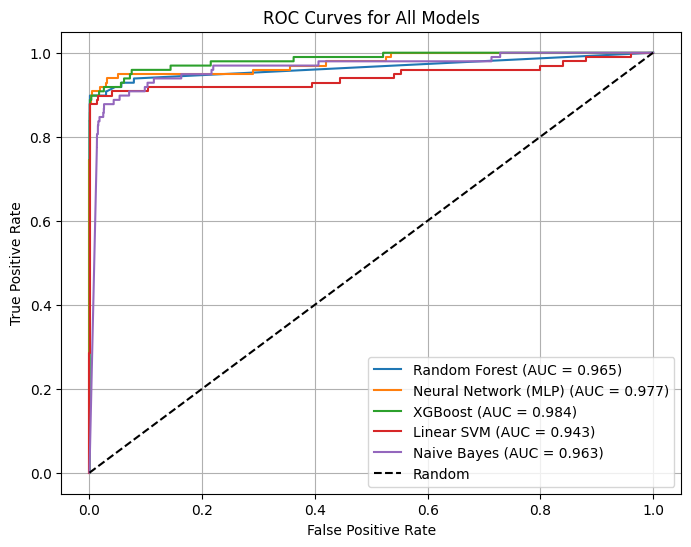

In [27]:
plt.figure(figsize = (8,6))

for name, scores in [
    ("Random Forest", rf_scores),
    ("Neural Network (MLP)", mlp_scores),
    ("XGBoost", xgb_scores),
    ("Linear SVM", svm_scores),
    ("Naive Bayes", nb_scores)
]:
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label = f"{name} (AUC = {auc:.3f})")

plt.plot([0,1], [0,1], 'k--', label = "Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()

## Precision-Recall Curves (Top 3 Models)

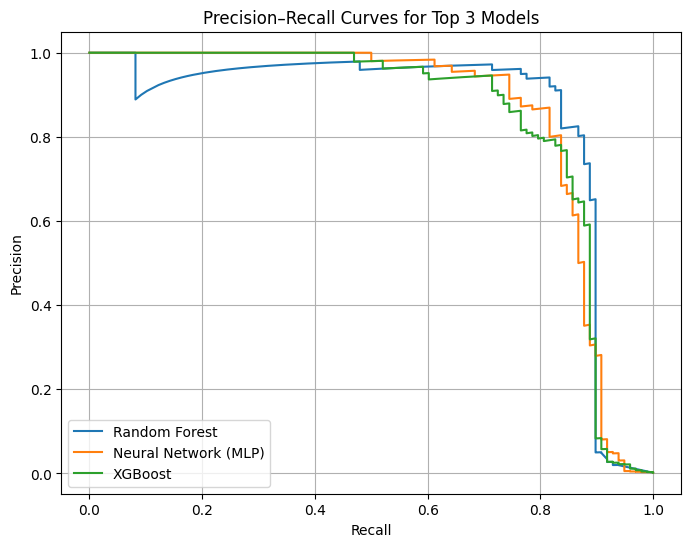

In [28]:
plt.figure(figsize = (8,6))

for name, scores in [
    ("Random Forest", rf_scores),
    ("Neural Network (MLP)", mlp_scores),
    ("XGBoost", xgb_scores)
]:
    precision, recall, _ = precision_recall_curve(y_test, scores)
    plt.plot(recall, precision, label = name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves for Top 3 Models")
plt.legend()
plt.grid(True)
plt.show()